**Authors:**

    Arno Moonens - 500513 - arno.moonens@vub.ac.be
    
    Jens Nevens - 500093 - jens.nevens@vub.ac.be

# Perceptron Learning Algorithm (PLA)

## Learning from Data: Homework 1

The following questions from this homework will be answered and its solutions will be explained: questions 7, 8, 9 and 10.

### Exercise:

In this problem, you will create your own target function $f$ and data set $\mathcal{D}$ to see how the Perceptron Learning Algorithm works. Take $d = 2$ so you can visualize the problem, and assume $\mathcal{X} = [ 1, 1] \times [ 1, 1]$ with uniform probability of picking each $x \in \mathcal{X}$.

In each run, choose a random line in the plane as your target function $f$ (do this by taking two random, uniformly distributed points in $[ 1, 1] \times [ 1, 1]$ and taking the line passing through them), where one side of the line maps to $+1$ and the other maps to $-1$. Choose the inputs $x_n$ of the data set as random points (uniformly in $\mathcal{X}$), and evaluate the target function on each $x_n$ to get the corresponding output $y_n \in \mathcal{Y}$.

In [47]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
# Load the data set
with open('dataset.pickle', 'rb') as f:
    dataset = pickle.load(f)

In [49]:
# Generate a random target function
def generate_target():
    p = np.random.uniform(-1, 1, (2,2))

    x = [[z,1] for z in p[:,0]]
    y = p[:,1]
    a,b = np.linalg.solve(x,y)
    
    w = [-b, -a, 1]
    
    Ys = np.sign(np.dot(dataset, w))
    return (w, Ys)

In [50]:
# Pick a random data set of the required size
def pick_data(targets, N, dim):
    Xs = np.zeros((N,dim))
    Ys = np.zeros(N)

    for i in range(N):
        idx = np.random.randint(0, len(dataset))
        Xs[i] = dataset[idx]
        Ys[i] = targets[idx]
    return (Xs, Ys)

First, we explain the Perceptron and the Perceptron Learning Algorithms:

### Perceptron

Consider a hypothesis set $\mathcal{H}$, where each hypothesis $h \in \mathcal{H}$ has a functional form. This functional form gives different weights to the different coordinates of the input vector $x$, reflecting their relative importance. These weighted coordinates are then combinated and compared to a threshold value. If the resulting value is above or below the threshold, a positive, respectively, negative output is returned. The function form of the hypothesis $h$ can be written as:

$$h(x) = sign \left( \left( \sum_{i=1}^{d}{w_i x_i} \right) + b \right)$$

where $x_1, \ldots, x_d$ are the components of the input vector $x$ and $sign(s) = +1$, if $s > 0$, while $sign(s) = -1$, if $s < 0$. The weights which are uses to weigh the coordinates are $w_1, \ldots, w_d$ and the threshold is determined by the term $b$. This model of the hypothesis set $\mathcal{H}$ is called the _perceptron_.

### Perceptron Learning Algorithm (PLA)

The learning algorithm used to search the hypothesis space $\mathcal{H}$ will look for weights and a bias term that performs well on the data set. Some of the weights might become negative, indicating an adverse effect for the corresponding components of the input vector $x$, while other weights can become positive. The optimal choices of the weight vector and the bias term define the final hypothesis $g \in \mathcal{H}$ that the algorithm produces. However, this final hypothesis $g$ will only be able to classify all training examples correctly when the data set is _linearly separable_.

To enable vector notation, we will consider the bias term $b$ as a weight $w_0 = b$. So the weight vector $w$ becomes $w = [w_0, w_1, \ldots, w_d]$. Similarly, the input vector $x$ is extended with the fixed value $x_0 = 1$. So, $x$ becomes $x = [x_0, x_1, \ldots, x_d]$. With this notation, the hypothesis $h$ can be written as

$$h(x) = sign(w^T x)$$

The Perceptron Learning Algorithm (PLA) will determine the weight vector $w$, based on the data. Assuming the given data is linearly separable, there exists a weight vector $w$ such that the hypothesis $h$ classifies all training points correctly, i.e. $h(x_n) = y_n$ for all $n$. This is done by a simple iterative method. At iteration $t$, where $t=0,1,2,\ldots$ the current value of the weight vector $w$ is denoted $w(t)$. The algorithm picks a misclassified example, denoted $(x(t), y(t))$, and uses this point to update $w(t)$. Since the chosen example is misclassified, we have $y(t) \ne sign(w^T(t) x(t))$. The update rule is

$$w(t+1) = w(t) + y(t)x(t)$$

This rule moves the boundary that classifies the points in the direction of classifying the point $x(t)$ correctly. This iterative procedure is repeated until there are no more misclassified examples in the data set.

Although the update rule considers only one training example at a time, this algorithm is indeed guaranteed to arrive at the correct solution (given the data is linearly separable). This holds regardless of which misclassified example $(x(t), y(t))$ is chosen and regardless of how the weight vector $w$ is initialized.

### The Code

The code below, more specfically the **PLA** function, implementes this Perceptron Learning Algorithm. The arguments for this function are the amount of iterations to perform, the size of the dataset $N$ and the dimension of the dataset. The algorithm starts by first generating a random target function (**generate_target** function). This returns the weight vector $w$ and the correct outputs $\mathcal{Y}$ for all data points in the dataset. Next, a random subset of size $N$ of the data is chosen and the weight vector $w_{est}$ that will be learned is filled with zeros. Then the algorithm's main loop begins.

In every iteration of this main loop, the following actions are done; First, the hypothesis $g$ is calculated as specified above, namely $sign(w_{est}^T, x)$. Next, all missclassified data points (or $x$'s) and their corresponding output values (or $y$'s) are collected in the **wrong_Xs** and **wrong_Ys** arrays respectively. These will be usefull for implementing the update rule. The accuracy is determined by counting the number of correctly classified examples. If not all points are correctly classified, a random missclassified point is chosen. For this, the two arrays mentioned above are used. This randomly chosen missclassified point is used to execute the PLA update rule, namely $w_{est} = w_{est} + yx$.

In order to determine the value for $\mathbb{P}[f(x) \ne g(x)]$, or the probability that $f$ and $g$ will disagree on their classification of a random point, the function **error_rate** is used. This function will take as input the actual weight vector $w$ from the target function and the learned weight vector $w_{est}$ and compute the output values for the entire dataset, once for each of these weight vectors. The error rate is then determined by counting the amount of missclassified points.

In [51]:
def error_rate(w, w_est):
    actual_Ys = np.sign(np.dot(dataset, w))
    predicted_Ys = np.sign(np.dot(dataset, w_est))

    return np.mean(actual_Ys != predicted_Ys)

In [60]:
def plot_convergence(iterations, convergence):
    plt.figure()
    plt.xlabel('Iterations')
    plt.ylabel('Steps')
    plt.title('Number of steps needed to converge per iteration')
    plt.bar(range(iterations), convergence, color='blue')
    plt.show()
    
def plot_error_rates(iterations, error_rates):
    plt.figure()
    plt.xlabel('Iterations')
    plt.ylabel('Error Rate')
    plt.title('Error rate per iteration')
    plt.bar(range(iterations), error_rates)
    plt.show()

In [61]:
# Main PLA Algorithm
def PLA(iterations, N, dim):
    convergence = np.zeros(iterations)
    error_rates = np.zeros(iterations)

    for i in range(iterations):
        w, Y = generate_target()
        Xs, Ys = pick_data(Y, N, dim)
        w_est = np.zeros(dim)
        ctr = 0
        acc = 0
        while acc < 1:
            ctr += 1
            # Make and evaluate predictions
            pred = np.sign(np.dot(Xs, w_est))
            wrong_Xs = Xs[pred != Ys]
            wrong_Ys = Ys[pred != Ys]
        
            # Measure accuracy of current iteration
            acc = np.mean(pred == Ys)
        
            # Randomly pick one misclassified point and update weight
            if acc < 1:
                idx = np.random.randint(len(wrong_Xs))
                w_est = w_est + wrong_Ys[idx] * wrong_Xs[idx]        
        convergence[i] = ctr
        error_rates[i] = error_rate(w, w_est)
    plot_convergence(iterations, convergence)
    plot_error_rates(iterations, error_rates)
    return (np.mean(convergence), np.mean(error_rates))

In [62]:
# Run the PLA algorithm for X iterations, with Y data points
def main(iterations, N):
    dim = dataset.shape[1]
    conv, err_rate = PLA(iterations, N, dim)
    return (conv, err_rate)

### Questions 7

How many iterations does it take on average for the PLA to converge for $N = 10$ training points?

### Question 8

Which of the following is closest to $\mathbb{P}[f(x) \ne g(x)]$ for $N = 10$?

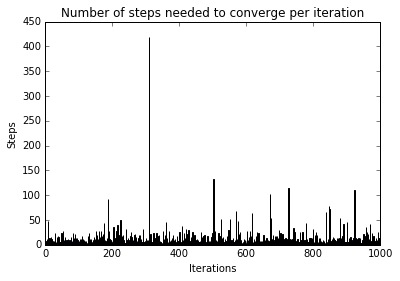

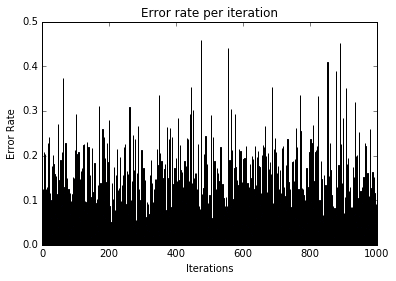

PLA run for 1000 iterations
Dataset of size 10
Average number of iterations needed for convergence is 10.144
Average error rate is 0.106439


In [63]:
conv, err_rate = main(1000,10)
print("PLA run for 1000 iterations")
print("Dataset of size 10")
print("Average number of iterations needed for convergence is", conv)
print("Average error rate is", err_rate)

The average number of iterations needed to reach convergence is closest to the one of answer B ($15$).

The average error rate is closest to the one of answer C ($0.1$).

### Questions 9

How many iterations does it take on average for the PLA to converge for $N = 100$ training points?

### Question 10

Which of the following is closest to $\mathbb{P}[f(x) \ne g(x)]$ for $N = 100$?

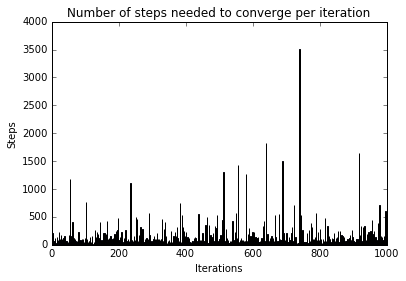

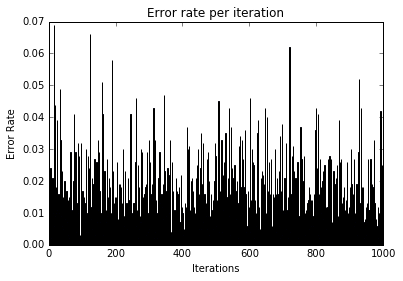

PLA run for 1000 iterations
Dataset of size 100
Average number of iterations needed for convergence is 102.424
Average error rate is 0.012136


In [56]:
conv, err_rate = main(1000,100)
print("PLA run for 1000 iterations")
print("Dataset of size 100")
print("Average number of iterations needed for convergence is", conv)
print("Average error rate is", err_rate)

The average number of iterations needed to reach convergence is closest to the one of answer B ($100$).

The average error rate is closest to the one of answer B ($0.01$).